In [691]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from scipy import stats
from scipy.stats import norm, skew 

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [692]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [693]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [694]:
print('Size of the sets')
train.shape, test.shape

Size of the sets


((891, 12), (418, 11))

In [695]:
passengerID = test.PassengerId

Count the number of survived and dead

In [696]:
train.Survived.value_counts()

0    549
1    342
Name: Survived, dtype: int64

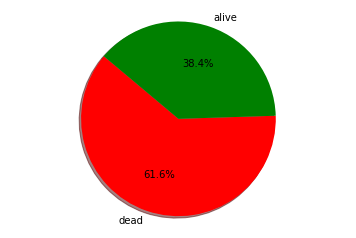

In [697]:
# Plot
plt.pie(train.Survived.value_counts(), labels=['dead','alive'], colors=['red','green'],
        autopct='%1.1f%%', shadow=True, startangle=140)
 
plt.axis('equal')
plt.show()

### Concatenate the train set and test set

In [698]:
data = pd.concat((train,test))
data.shape

(1309, 12)

Find Title to fill age

In [699]:
data['Title'] = data['Name']
for string in data['Name']:
    data['Title'] = data['Name'].str.extract('([A-Za-z]+)\.', expand = True)

In [700]:
data.Title.value_counts()

Mr          757
Miss        260
Mrs         197
Master       61
Rev           8
Dr            8
Col           4
Ms            2
Mlle          2
Major         2
Sir           1
Don           1
Capt          1
Jonkheer      1
Dona          1
Countess      1
Mme           1
Lady          1
Name: Title, dtype: int64

In [701]:
data.index[data.Title == 'Capt'].tolist() # index of the captain

[745]

In [702]:
data = data.drop(data[data.Title == 'Capt'].index) # drop the captain bc he died for the ship
# Replacing unimportant titles with more common ones
mapping = {'Mlle': 'Miss', 'Ms' : 'Miss', 'Rev' : 'Mr', 'Col' : 'Mr', 'Major' : 'Mr', 'Countess' : 'Miss',
          'Jonkheer' : 'Mr', 'Sir' : 'Mr', 'Mme' : 'Mrs', 'Don' : 'Mr', 'Lady' : 'Mrs', 'Dona' : 'Mrs'}
data.replace({'Title' : mapping}, inplace = True)

In [703]:
titles = ['Mr','Miss','Mrs', 'Master', 'Dr']
for title in titles:
    age_impute = data.groupby('Title')['Age'].median()[titles.index(title)]
    data.loc[(data['Age'].isnull()) & (data['Title'] == title), 'Age'] = age_impute

In [704]:
data_na = data.isnull().sum()
data_na = data_na.drop(data_na[data_na == 0].index).sort_values(ascending=False)
missing_data = pd.DataFrame({'Missing Value' :data_na})
missing_data.head()

,Missing Value
Cabin,1014
Survived,418
Embarked,2
Fare,1


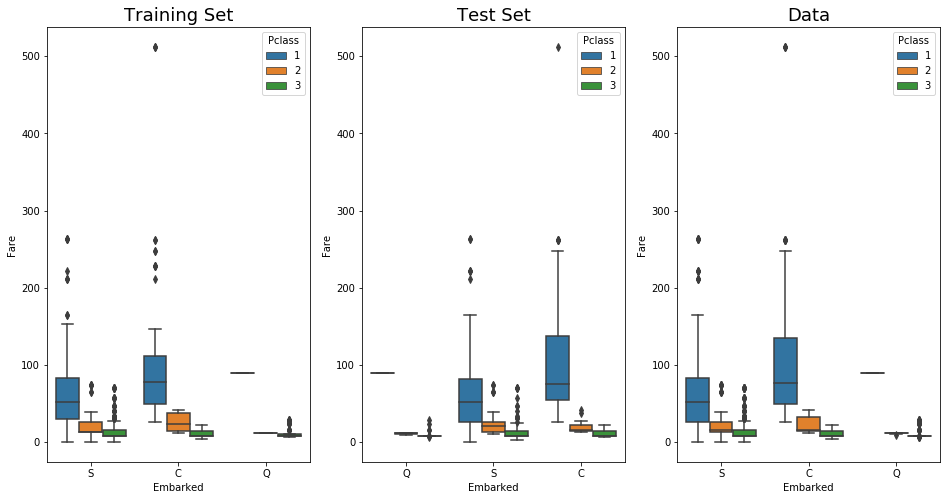

In [705]:
fig, ax = plt.subplots(figsize=(16,8),ncols=3)
ax1 = sns.boxplot(x="Embarked", y="Fare", hue="Pclass", data=train, ax = ax[0])
ax2 = sns.boxplot(x="Embarked", y="Fare", hue="Pclass", data=test, ax = ax[1])
ax3 = sns.boxplot(x="Embarked", y="Fare", hue="Pclass", data=data, ax = ax[2])
ax1.set_title("Training Set", fontsize = 18)
ax2.set_title('Test Set',  fontsize = 18)
ax3.set_title('Data',  fontsize = 18)
fig.show()

In [706]:
## Replacing the null values in the Embarked column with the mode. 
data.Embarked.fillna("C", inplace=True)

In [707]:
fare = data[data.Fare.isnull()]
fare

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Title
152,60.5,NaN,S,NaN,"Storey, Mr. Thomas",0,1044,3,male,0,NaN,3701,Mr


In [708]:
data["Fare"] = data.groupby("Pclass")["Fare"].transform(lambda x: x.fillna(x.median()))

Find missing columns

In [709]:
data_na = data.isnull().sum()
data_na = data_na.drop(data_na[data_na == 0].index).sort_values(ascending=False)
missing_data = pd.DataFrame({'Missing Value' :data_na})
missing_data.head()

,Missing Value
Cabin,1014
Survived,418


### Visualization of the data

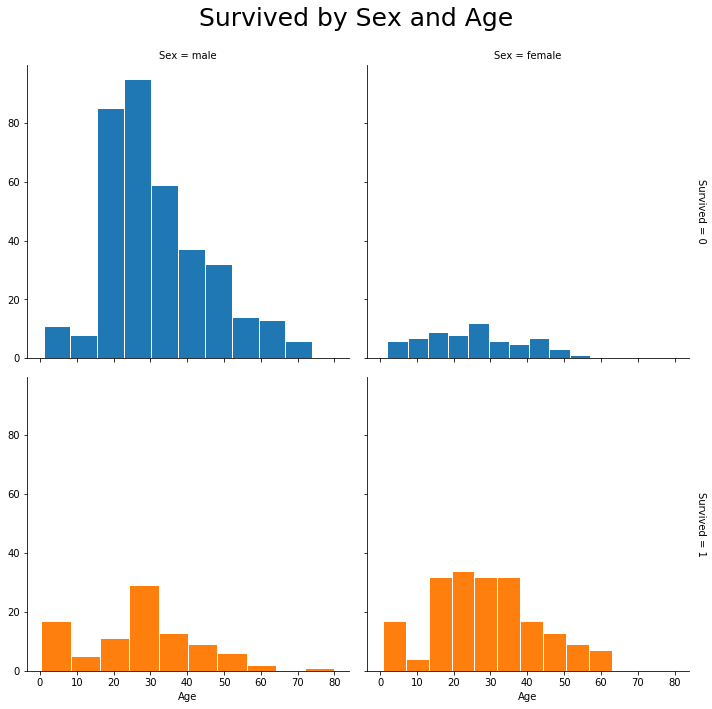

In [710]:
g = sns.FacetGrid(train,size=5, col="Sex", row="Survived", margin_titles=True, hue = "Survived",)
g = g.map(plt.hist, "Age", edgecolor = 'white');
g.fig.suptitle("Survived by Sex and Age", size = 25)
plt.subplots_adjust(top=0.90)

Text(0.5, 1.0, 'Survival Rates Based on Gender and Class')

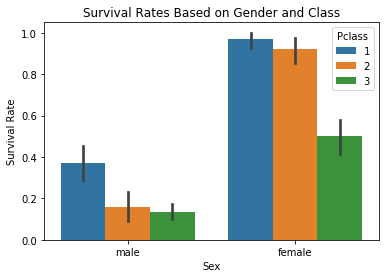

In [711]:
sns.barplot(x="Sex", y="Survived", hue="Pclass", data=train)
plt.ylabel("Survival Rate")
plt.title("Survival Rates Based on Gender and Class")

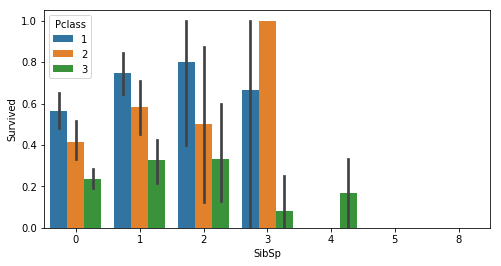

In [712]:
fig, ax = plt.subplots(figsize=(8,4))
g = sns.barplot(x="SibSp", y="Survived", hue="Pclass", data=train)

Text(0.5, 1.0, 'Survival Rates Based on Gender and Class')

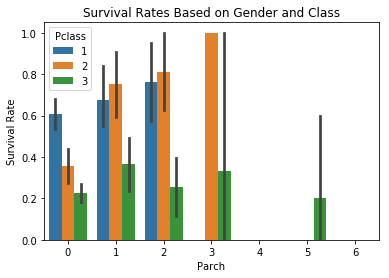

In [713]:
sns.barplot(x="Parch", y="Survived", hue="Pclass", data=train)
plt.ylabel("Survival Rate")
plt.title("Survival Rates Based on Gender and Class")

We can see that the two features have same distribution of survival rate. So we join them in one as Family_Size column

In [714]:
data['Family_Size'] = data['Parch'] + data['SibSp'] + 1

In [715]:
data['Last_Name'] = data['Name'].apply(lambda x: str.split(x, ",")[0])

DEFAULT_SURVIVAL_VALUE = 0.5
data['Family_Survival'] = DEFAULT_SURVIVAL_VALUE

for grp, grp_df in data[['Survived','Name', 'Last_Name', 'Fare', 'Ticket', 'PassengerId',
                           'SibSp', 'Parch', 'Age', 'Cabin']].groupby(['Last_Name', 'Fare']):
    
    if (len(grp_df) != 1):
        # A Family group is found.
        for ind, row in grp_df.iterrows():
            smax = grp_df.drop(ind)['Survived'].max()
            smin = grp_df.drop(ind)['Survived'].min()
            passID = row['PassengerId']
            if (smax == 1.0):
                data.loc[data['PassengerId'] == passID, 'Family_Survival'] = 1
            elif (smin==0.0):
                data.loc[data['PassengerId'] == passID, 'Family_Survival'] = 0

print("Number of passengers with family survival information:", 
      data.loc[data['Family_Survival']!=0.5].shape[0])

Number of passengers with family survival information: 418


In [716]:
for _, grp_df in data.groupby('Ticket'):
    if (len(grp_df) != 1):
        for ind, row in grp_df.iterrows():
            if (row['Family_Survival'] == 0) | (row['Family_Survival']== 0.5):
                smax = grp_df.drop(ind)['Survived'].max()
                smin = grp_df.drop(ind)['Survived'].min()
                passID = row['PassengerId']
                if (smax == 1.0):
                    data.loc[data['PassengerId'] == passID, 'Family_Survival'] = 1
                elif (smin==0.0):
                    data.loc[data['PassengerId'] == passID, 'Family_Survival'] = 0
                        
print("Number of passenger with family/group survival information: " 
      +str(data[data['Family_Survival']!=0.5].shape[0]))

Number of passenger with family/group survival information: 544


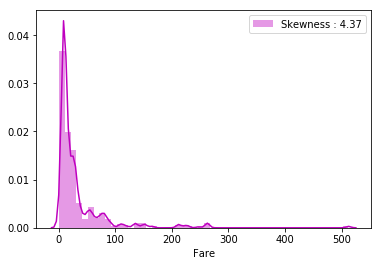

In [717]:
# Explore Fare distribution 
g = sns.distplot(data["Fare"], color="m", label="Skewness : %.2f"%(data["Fare"].skew()))
g = g.legend(loc="best")

In [718]:
# Apply log to Fare to reduce skewness distribution
data["Fare"] = data["Fare"].map(lambda i: np.log(i) if i > 0 else 0)

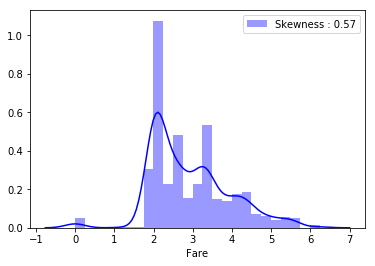

In [719]:
g = sns.distplot(data["Fare"], color="b", label="Skewness : %.2f"%(data["Fare"].skew()))
g = g.legend(loc="best")

In [720]:
# Making Bins
from sklearn.preprocessing import LabelEncoder

data['Fare'] = pd.qcut(data['Fare'], 4)
data['Age'] = pd.qcut(data['Age'], [0, .05, .85, .95, 1.])

cols = ['Fare', 'Age', 'Sex']
label_enc = LabelEncoder()
for c in cols:
    label_enc.fit(list(data[c].values)) 
    data[c] = label_enc.transform(list(data[c].values))

In [721]:
data.drop(['Title', 'Name', 'Ticket', 'Cabin', 'PassengerId', 'Last_Name', 'Embarked', 'Parch', 'SibSp'], 
          axis = 1, inplace = True)

In [722]:
train = data[:890]
test = data[890:]

In [723]:
y_value = train.Survived.values
train = train.drop('Survived', axis = 1)
X_train = train
test = test.drop('Survived', axis = 1)

In [724]:
from sklearn.preprocessing import StandardScaler
std_scaler = StandardScaler()
train = std_scaler.fit_transform(train)
test = std_scaler.transform(test)

In [725]:
# import all the necessary libraries
from sklearn.linear_model import BayesianRidge, LinearRegression, Ridge, SGDRegressor, LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor, AdaBoostClassifier, ExtraTreesClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.kernel_ridge import KernelRidge
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import mean_squared_error, accuracy_score
import xgboost as xgb
import lightgbm as lgb

In [726]:
models = [GradientBoostingClassifier(), SVC(), AdaBoostClassifier(),
          xgb.XGBClassifier(), lgb.LGBMClassifier(), RandomForestClassifier(), KNeighborsClassifier(),
          GaussianNB(), ExtraTreesClassifier(), LinearDiscriminantAnalysis(), QuadraticDiscriminantAnalysis()]

In [727]:
names = ["GBR","SVC","Ada", "Xgb","Lbg", "RF", "KNC", "GNB", "Xtree", "LDA", "QDA"]
dict_score = {}
for name, model in zip(names, models):
    model.fit(train, y_value)
    model_train_pred = model.predict(train).astype(int)
    accy = round(accuracy_score(y_value, model_train_pred), 6)
    dict_score[name] = [accy]

import operator
dict_score = sorted(dict_score.items(), key = operator.itemgetter(1), reverse = True)
dict_score

[('RF', [0.882022]),
 ('Xtree', [0.882022]),
 ('Lbg', [0.869663]),
 ('KNC', [0.859551]),
 ('GBR', [0.857303]),
 ('SVC', [0.848315]),
 ('Xgb', [0.848315]),
 ('LDA', [0.839326]),
 ('Ada', [0.825843]),
 ('QDA', [0.801124]),
 ('GNB', [0.782022])]

In [728]:
ETree = ExtraTreesClassifier()
RF = RandomForestClassifier()
LBG = lgb.LGBMClassifier()
KNC = KNeighborsClassifier()
GBR = GradientBoostingClassifier()

In [729]:
ETreeMd = ETree.fit(train, y_value)
RFMd = RF.fit(train, y_value)
LBGMd = LBG.fit(train, y_value)
KNCMd = KNC.fit(train, y_value)
GBRMd = GBR.fit(train, y_value)

In [734]:
y_pred = RFMd.predict(test).astype(int)

In [737]:
y_pred = ((ETreeMd.predict(test).astype(int) + RFMd.predict(test).astype(int) + LBGMd.predict(test).astype(int) +
           KNCMd.predict(test).astype(int) + GBRMd.predict(test).astype(int))/5).astype(int)
y_pred

array([0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1,
       1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0,
       1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,

### Another stacking ensemble

In [461]:
# Adaboost
DTC = DecisionTreeClassifier()

adaDTC = AdaBoostClassifier(DTC, random_state=7)

ada_param_grid = {"base_estimator__criterion" : ["gini", "entropy"],
              "base_estimator__splitter" :   ["best", "random"],
              "algorithm" : ["SAMME","SAMME.R"],
              "n_estimators" :[1,2],
              "learning_rate":  [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3,1.5]}

gsadaDTC = GridSearchCV(adaDTC,param_grid = ada_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsadaDTC.fit(train,y_value)

ada_best = gsadaDTC.best_estimator_

gsadaDTC.best_score_

Fitting 10 folds for each of 112 candidates, totalling 1120 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 249 tasks      | elapsed:    3.5s
[Parallel(n_jobs=4)]: Done 1120 out of 1120 | elapsed:    5.3s finished


In [462]:
#ExtraTrees 
ExtC = ExtraTreesClassifier()

## Search grid for optimal parameters
ex_param_grid = {"max_depth": [None],
              "max_features": [1, 3, 6],
              "min_samples_split": [2, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [False],
              "n_estimators" :[100,300],
              "criterion": ["gini"]}


gsExtC = GridSearchCV(ExtC,param_grid = ex_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsExtC.fit(train,y_value)

ExtC_best = gsExtC.best_estimator_

# Best score
gsExtC.best_score_

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 10 folds for each of 54 candidates, totalling 540 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    4.5s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   21.4s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   52.9s
[Parallel(n_jobs=4)]: Done 540 out of 540 | elapsed:  1.1min finished


0.8438202247191011

In [463]:
# RFC Parameters tunning 
RFC = RandomForestClassifier()


## Search grid for optimal parameters
rf_param_grid = {"max_depth": [None],
              "max_features": [1, 3, 6],
              "min_samples_split": [2, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [False],
              "n_estimators" :[100,300],
              "criterion": ["gini"]}


gsRFC = GridSearchCV(RFC,param_grid = rf_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsRFC.fit(train,y_value)

RFC_best = gsRFC.best_estimator_

# Best score
gsRFC.best_score_

Fitting 10 folds for each of 54 candidates, totalling 540 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.9s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   22.5s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   57.1s
[Parallel(n_jobs=4)]: Done 540 out of 540 | elapsed:  1.2min finished


0.8382022471910112

In [464]:
# Gradient boosting tunning

GBC = GradientBoostingClassifier()
gb_param_grid = {'loss' : ["deviance"],
              'n_estimators' : [100,200,300],
              'learning_rate': [0.1, 0.05, 0.01],
              'max_depth': [4, 8],
              'min_samples_leaf': [100,150],
              'max_features': [0.3, 0.1] 
              }

gsGBC = GridSearchCV(GBC,param_grid = gb_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsGBC.fit(train,y_value)

GBC_best = gsGBC.best_estimator_

# Best score
gsGBC.best_score_

Fitting 10 folds for each of 72 candidates, totalling 720 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    3.8s
[Parallel(n_jobs=4)]: Done 376 tasks      | elapsed:   17.5s
[Parallel(n_jobs=4)]: Done 720 out of 720 | elapsed:   33.7s finished


0.8460674157303371

In [467]:
SVMC = SVC(probability=True)
svc_param_grid = {'kernel': ['rbf'], 
                  'gamma': [ 0.001, 0.01, 0.1, 1],
                  'C': [1, 10, 50, 100,200,300, 1000]}

gsSVMC = GridSearchCV(SVMC,param_grid = svc_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsSVMC.fit(train,y_value)

SVMC_best = gsSVMC.best_estimator_

# Best score
gsSVMC.best_score_

Fitting 10 folds for each of 28 candidates, totalling 280 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.2s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   12.3s
[Parallel(n_jobs=4)]: Done 280 out of 280 | elapsed:   25.8s finished


0.8438202247191011

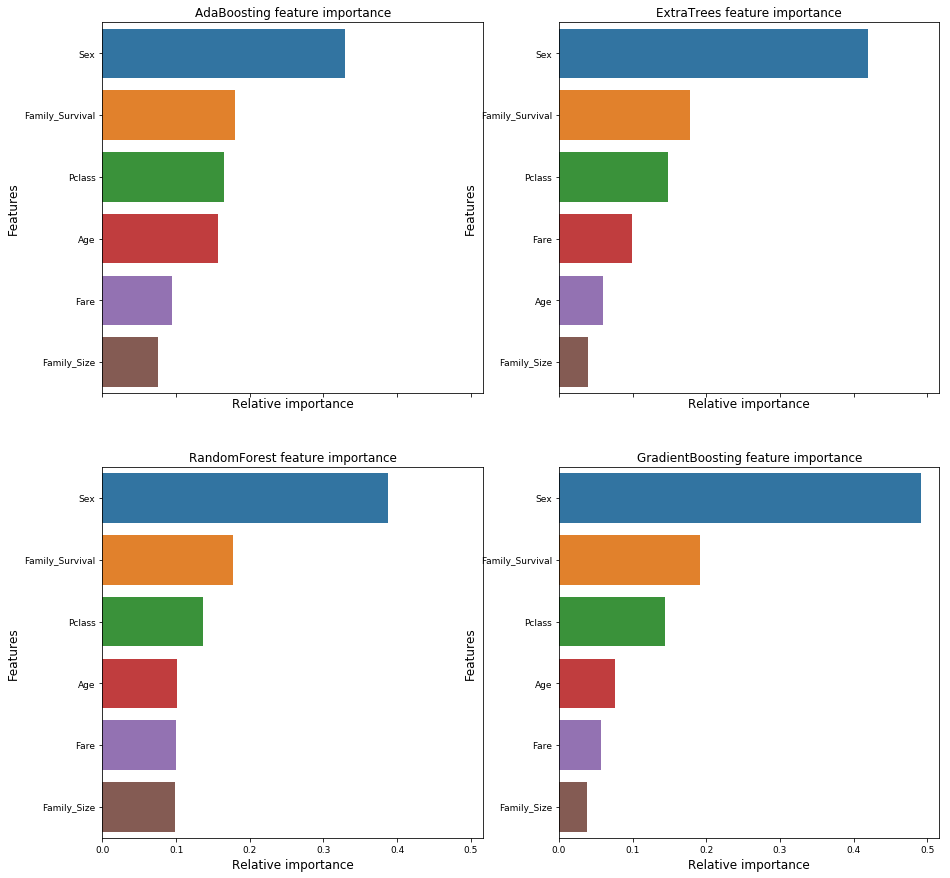

In [465]:
nrows = ncols = 2
fig, axes = plt.subplots(nrows = nrows, ncols = ncols, sharex="all", figsize=(15,15))

names_classifiers = [("AdaBoosting", ada_best),("ExtraTrees",ExtC_best),("RandomForest",RFC_best),("GradientBoosting",GBC_best)]

nclassifier = 0
for row in range(nrows):
    for col in range(ncols):
        name = names_classifiers[nclassifier][0]
        classifier = names_classifiers[nclassifier][1]
        indices = np.argsort(classifier.feature_importances_)[::-1][:40]
        g = sns.barplot(y = X_train.columns[indices][:40],x = classifier.feature_importances_[indices][:40] , orient='h',ax=axes[row][col])
        g.set_xlabel("Relative importance",fontsize=12)
        g.set_ylabel("Features",fontsize=12)
        g.tick_params(labelsize=9)
        g.set_title(name + " feature importance")
        nclassifier += 1

In [468]:
votingC = VotingClassifier(estimators=[('rfc', RFC_best), ('extc', ExtC_best), ('svc', SVMC_best),
                                       ('adac',ada_best),('gbc',GBC_best)], voting='soft', n_jobs=4)

votingC = votingC.fit(X_train, y_value)
y_pred = votingC.predict(test).astype(int)

## Stacking prediction

In [740]:
from mlxtend.regressor import StackingRegressor

stregr = StackingRegressor(regressors=[ETree,LBG, KNC, GBR, RF], 
                           meta_regressor= RF)

stregr.fit(train, y_value)
stregr_train_pred = stregr.predict(train).astype(int)
accy = round(accuracy_score(y_value, stregr_train_pred), 3)
print(accy)

0.882


In [741]:
y_pred = stregr.predict(test).astype(int)
y_pred

array([0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0,
       1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1,
       1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0,
       1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1,
       0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1,
       0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,

## OOF prediction

In [744]:
nfolds = 5 # set folds for out-of-fold prediction

def get_oof(model, x_train, y_train, x_test):
    oof_train = np.zeros((train.shape[0],))
    oof_test = np.zeros((test.shape[0],))
    oof_test_skf = np.empty((nfolds, test.shape[0]))
    
    kf = KFold(nfolds, shuffle=False, random_state=42).split(train)

    for i, (train_index, test_index) in enumerate(kf):
        x_tr = x_train[train_index]
        y_tr = y_train[train_index]
        x_te = x_train[test_index]

        model.fit(x_tr, y_tr)

        oof_train[test_index] = model.predict(x_te)
        oof_test_skf[i, :] = model.predict(x_test)

    oof_test[:] = oof_test_skf.mean(axis=0)
    return oof_train.reshape(-1, 1), oof_test.reshape(-1, 1)

In [745]:
ETree_oof_train, ETree_oof_test = get_oof(ETree, train, y_value, test)
KNC_oof_train, KNC_oof_test = get_oof(KNC, train, y_value, test)
RF_oof_train, RF_oof_test = get_oof(RF, train, y_value, test)
LBG_oof_train, LBG_oof_test = get_oof(LBG, train, y_value, test)
GBR_oof_train, GBR_oof_test = get_oof(GBR, train, y_value, test)

In [746]:
x_train = np.concatenate((ETree_oof_train, KNC_oof_train, RF_oof_train, LBG_oof_train, GBR_oof_train), axis=1)
x_test = np.concatenate((ETree_oof_test, KNC_oof_test, RF_oof_test, LBG_oof_test, GBR_oof_test), axis=1)

In [747]:
Stacked_Model = ETree.fit(x_train, y_value)

n_folds = 5
kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(x_train)
train_pred = Stacked_Model.predict(x_train).astype(int)
accy = round(accuracy_score(y_value, train_pred), 3)
print(accy)

y_pred = Stacked_Model.predict(x_test).astype(int)
y_pred

0.856


array([0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1,
       1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,

## GridSearchCV

In [760]:
n_neighbors = [6,7,8,9,10,11,12,14,16,18,20,22]
algorithm = ['auto']
weights = ['uniform', 'distance']
leaf_size = list(range(1,50,5))
param_grid = { 
           "n_estimators" : [9, 18, 27, 36, 45, 54, 63],
           "max_depth" : [1, 5, 10, 15, 20, 25, 30],
           "min_samples_leaf" : [1, 2, 4, 6, 8, 10]}
gd=GridSearchCV(estimator = RandomForestClassifier(), param_grid = param_grid, verbose=True, 
                cv=10, scoring = "roc_auc", n_jobs=4)
gd.fit(train, y_value)
print(gd.best_score_)
print(gd.best_estimator_)

Fitting 10 folds for each of 294 candidates, totalling 2940 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.8985244904907825
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=2, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=45, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)


[Parallel(n_jobs=1)]: Done 2940 out of 2940 | elapsed:  2.7min finished


In [761]:
gd.best_estimator_.fit(train, y_value)
y_pred = gd.best_estimator_.predict(test).astype(int)

In [762]:
submission = pd.DataFrame({'PassengerId': passengerID, 'Survived': y_pred })
submission.to_csv("submission.csv", index=False)

In [763]:
submission

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1
5,897,0
6,898,1
7,899,0
8,900,1
9,901,0
